In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from collections import Counter
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import joblib

In [2]:
# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/harshasikha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/harshasikha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# Load datasets
true_df = pd.read_csv('True.csv')
fake_df = pd.read_csv('Fake.csv')

In [4]:
# Label data
true_df['label'] = 1  # Real news
fake_df['label'] = 0  # Fake news

In [5]:
# Combine datasets
df = pd.concat([true_df, fake_df], ignore_index=True)

In [6]:
print(df.head())

                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  label  
0  December 31, 2017       1  
1  December 29, 2017       1  
2  December 31, 2017       1  
3  December 30, 2017       1  
4  December 29, 2017       1  


In [7]:
print(df.info())
print(df['label'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB
None
label
0    23481
1    21417
Name: count, dtype: int64


In [8]:
# Set of stopwords
stop_words = set(stopwords.words('english'))

In [9]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/harshasikha/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [10]:
# Text Cleaning Function
def clean_text(text):
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\d', ' ', text)  # Remove digits
    text = text.lower()  # Convert to lowercase
    tokens = word_tokenize(text)  # Tokenize
    return ' '.join(word for word in tokens if word not in stop_words)

# Apply text cleaning
df['text'] = df['text'].apply(clean_text)

# Check for missing values
print(df.isnull().sum())

title      0
text       0
subject    0
date       0
label      0
dtype: int64


In [11]:
# Split dataset
X = df['text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

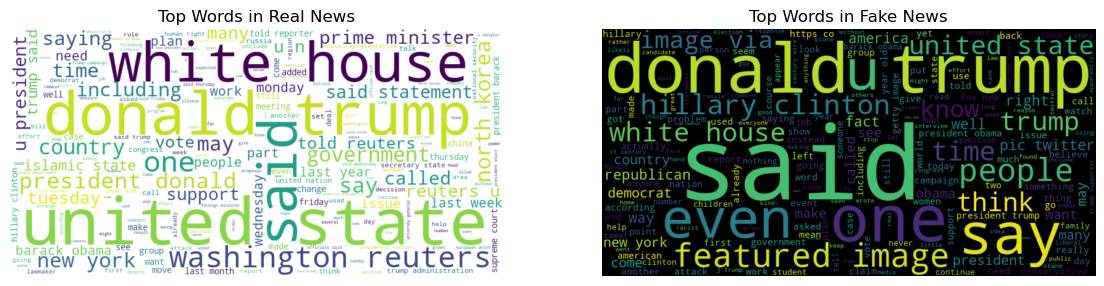

In [13]:
#Word Cloud for Fake vs. Real News
real_text = ' '.join(df[df['label'] == 1]['text'])
fake_text = ' '.join(df[df['label'] == 0]['text'])
real_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(real_text)
fake_wordcloud = WordCloud(width=800, height=400, background_color='black').generate(fake_text)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.imshow(real_wordcloud, interpolation='bilinear')
plt.title("Top Words in Real News")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(fake_wordcloud, interpolation='bilinear')
plt.title("Top Words in Fake News")
plt.axis('off')

plt.show()

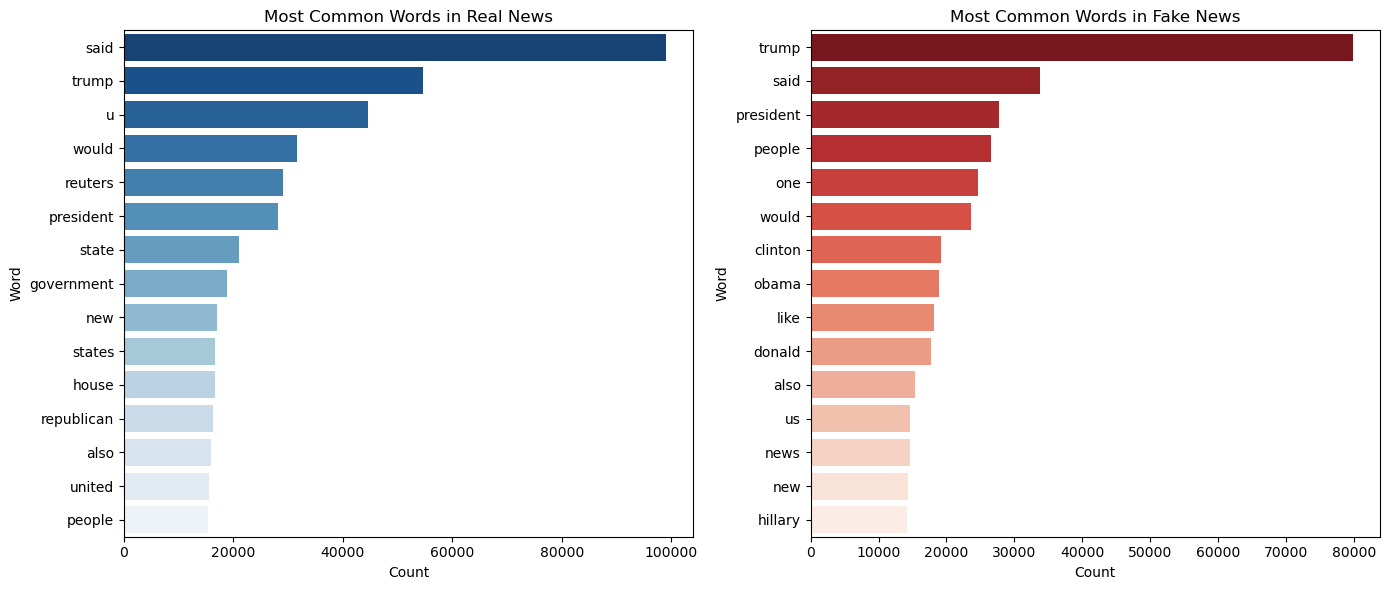

In [14]:
#Bar Chart for Most Common Words
real_words = real_text.split()
fake_words = fake_text.split()
real_common_words = Counter(real_words).most_common(15)
fake_common_words = Counter(fake_words).most_common(15)

real_df = pd.DataFrame(real_common_words, columns=['Word', 'Count'])
fake_df = pd.DataFrame(fake_common_words, columns=['Word', 'Count'])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.barplot(x='Count', y='Word', data=real_df, ax=axes[0], palette='Blues_r')
axes[0].set_title('Most Common Words in Real News')

sns.barplot(x='Count', y='Word', data=fake_df, ax=axes[1], palette='Reds_r')
axes[1].set_title('Most Common Words in Fake News')

plt.tight_layout()
plt.show()


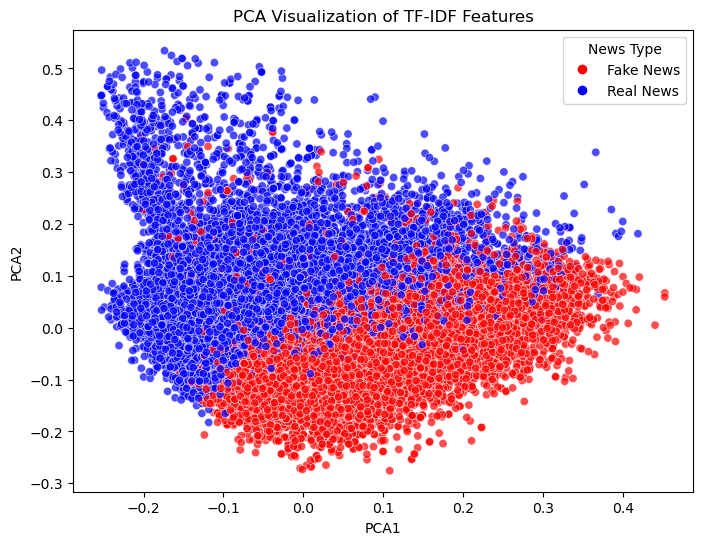

In [15]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Reduce dimensionality to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_tfidf.toarray())  # Convert sparse matrix to dense

# Convert to DataFrame
pca_df = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
pca_df['label'] = y_train.values  # Add labels
palette = {0: 'red', 1: 'blue'}  # 0 = Fake News (red), 1 = Real News (blue)

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='label', data=pca_df, palette=palette, alpha=0.7)

legend_labels = {'Fake News': 'red', 'Real News': 'blue'}
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=8) for color in legend_labels.values()]
plt.legend(handles, legend_labels.keys(), title="News Type")

plt.title('PCA Visualization of TF-IDF Features')
plt.show()


### Model Training & Evaluation

In [16]:
#  Logistic Regression (Fast SGD)
model = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, random_state=42)
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)
print("SGD Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


SGD Logistic Regression Accuracy: 0.9860801781737194
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      4650
           1       0.98      0.99      0.99      4330

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



**Efficiency:** SGD is highly efficient for large-scale datasets. It updates model weights incrementally, making it faster than standard Logistic Regression.


**Scalability:** Can handle high-dimensional text data, making it ideal for TF-IDF feature vectors.
Regularization Support: Includes L1 (Lasso) & L2 (Ridge) regularization, helping prevent overfitting.

SGD Logistic Regression Accuracy: 98.61%

**High Precision (0.99):** The model correctly identifies Fake News & Real News with minimal false positives.


**High Recall (0.99):** It successfully detects the majority of fake and real news articles.


**Balanced F1-Score (0.99):** Suggests a strong trade-off between precision & recall—ideal for fake news detection

In [17]:
# Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)

print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Classification Report:\n", classification_report(y_test, y_pred_nb))

Naive Bayes Accuracy: 0.9476614699331849
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95      4650
           1       0.95      0.95      0.95      4330

    accuracy                           0.95      8980
   macro avg       0.95      0.95      0.95      8980
weighted avg       0.95      0.95      0.95      8980



Used Multinomial Naive Bayes because:

**Text Classification Strength:** Naive Bayes performs well with high-dimensional text data, especially with TF-IDF features.


**Fast & Scalable:** It is computationally efficient, making it suitable for large datasets.

**Probabilistic Approach:** Estimates word probabilities for each class, making it interpretable and robust to noise.

**Good Precision & Recall (0.95):** Naive Bayes provides a well-balanced performance for both Fake & Real News.


**Slightly Lower Accuracy than SGD:** While Naive Bayes (94.77%) performs well, SGD Logistic Regression (98.61%) shows better classification power.

In [18]:
# 3️⃣ SVM (Fast SGD)
svm_model = SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3, random_state=42)
svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Classification Report:\n", classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.9928730512249443
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      4650
           1       0.99      1.00      0.99      4330

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



chose SVM with Stochastic Gradient Descent (SGD) because:

**Effective for High-Dimensional Data:** SVM works well with text-based features like TF-IDF.


**Margin Optimization:** Maximizes the margin between classes for better generalization.


**Scalability:** The SGD-based SVM is computationally efficient for large datasets.

**Highest Accuracy (99.29%):** The SVM model outperforms both SGD Logistic Regression (98.61%) and Naive Bayes (94.77%).


**Excellent Precision & Recall:** SVM achieves near-perfect classification, making it highly reliable.


**Better at Handling Class Overlap:** Unlike Naive Bayes, SVM finds the optimal decision boundary for improved classification.


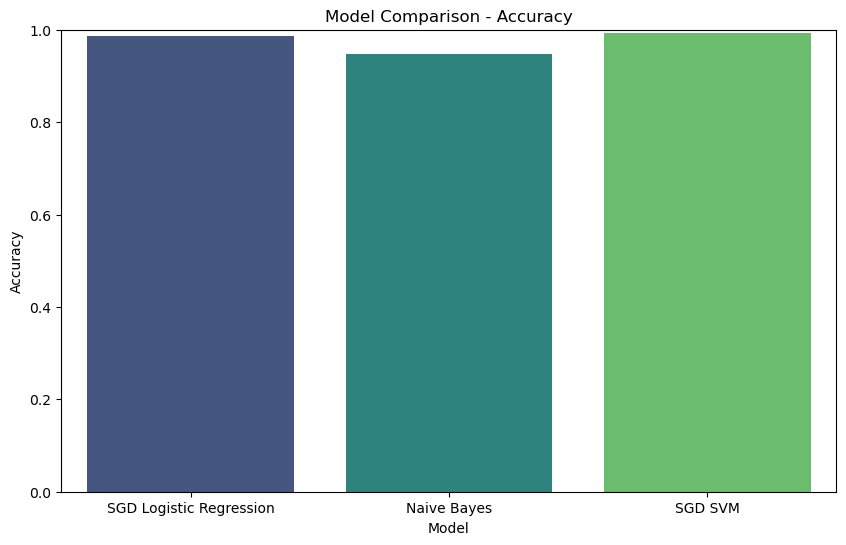

['best_fake_news_model.pkl']

In [19]:
# Compare Model Performance
accuracies = {
    'SGD Logistic Regression': accuracy_score(y_test, y_pred),
    'Naive Bayes': accuracy_score(y_test, y_pred_nb),
    'SGD SVM': accuracy_score(y_test, y_pred_svm),
}

plt.figure(figsize=(10, 6))
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette='viridis')
plt.title('Model Comparison - Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

# Save Best Model
joblib.dump(svm_model, 'best_fake_news_model.pkl')


In [20]:
# Save the trained TF-IDF vectorizer
joblib.dump(tfidf, "tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']

In [21]:
# Load the saved model and TF-IDF vectorizer
svm_model = joblib.load("best_fake_news_model.pkl")
tfidf_vectorizer = joblib.load("tfidf_vectorizer.pkl")

# Function to Predict Fake/Real News
def predict_news(news_text):
    # Preprocess the input
    news_tfidf = tfidf_vectorizer.transform([news_text])

    # Predict label
    prediction = svm_model.predict(news_tfidf)

    # Interpret result
    return "Real News" if prediction[0] == 1 else "Fake News"

# Test with a sample news article
sample_news = "Breaking: Scientists discover a new vaccine that prevents all virus infections."
result = predict_news(sample_news)

# Print the result
print(f"Sample News: {sample_news}\nPrediction: {result}")


Sample News: Breaking: Scientists discover a new vaccine that prevents all virus infections.
Prediction: Fake News
